# DTree for Docker CVEs 

This notebook is for Docker CVEs. We try to find a rule to detect cross-namespaces. 

In [47]:
from google.colab import drive
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Prepocessing Training Data

We train our DTree on the first CVEs we explore. CVE-2018-5736 and CVE-2018-15664. We used two to avoid underfitting of the DTree.

In [48]:
!ls gdrive/MyDrive/Data_Prov_New

0492_features.csv	 benchmark3_features.csv
14271_features.csv	 cve-30465-kube-features.csv
15664_features.csv	 features_audit_14271_allcol.csv
5736_features.csv	 features_audit_14271.csv
benchmark1_features.csv  features_excl_inter_pod.csv
benchmark2_features.csv  hotel_kube.csv


In [49]:
df1 = pd.read_csv("gdrive/MyDrive/Data_Prov_New/5736_features.csv")
df2 = pd.read_csv("gdrive/MyDrive/Data_Prov_New/15664_features.csv")
df1 = pd.concat([df1, df2])

### Limiting to inodes only

In [50]:
df1 = df1[(df1['object_type'] == 'link') | (df1['object_type'] == 'file') | (df1['object_type'] == 'directory') |  (df1['object_type'] == 'file,directory')|  (df1['object_type'] == 'directory,file')]
df1


,object_type,entity_path,reader_path,writer_path,namespaces,reader_relation_types,writer_relation_types,writer_argvs,reader_argvs,priviledged_flow,labels
0,file,['/var/lib/docker/overlay2/21efa2c02f6440f41f4...,"['/usr/bin/dockerd', '/usr/bin/docker-runc']",['/usr/bin/dockerd'],"[1, 1, 1, 1, 1]",['getattr'],['rename'],[],[],0,0
1,file,['/var/lib/docker/overlay2/21efa2c02f6440f41f4...,"['/usr/bin/dockerd', '/usr/bin/docker-runc']",['/usr/bin/dockerd'],"[1, 1, 1, 1, 1]",['getattr'],['rename'],[],[],0,0
2,file,['/var/lib/docker/overlay2/21efa2c02f6440f41f4...,"['/usr/bin/dockerd', '/usr/bin/docker-runc']",['/usr/bin/dockerd'],"[1, 1, 1, 1, 1]",['getattr'],['rename'],[],[],0,0
5,file,"['/systemd/netif/state', '/systemd/netif/.#sta...","['/lib/systemd/systemd-timesyncd', '/bin/netwo...",['/lib/systemd/systemd-networkd'],"[0, 1, 0, 0, 0]","['getattr', 'perm_check', 'open', 'read']","['write', 'rename']",[],[],0,0
6,file,"['/systemd/netif/links/13', '/systemd/netif/li...","['/lib/systemd/systemd-resolved', '/usr/bin/py...",['/lib/systemd/systemd-networkd'],"[0, 1, 0, 0, 0]","['getattr', 'open', 'perm_check', 'read']","['write', 'rename']",[],"['--no-legend', '/bin/networkctl', '--no-pager...",0,0
7,file,"['/systemd/resolve/stub-resolv.conf', '/system...",['/usr/bin/dockerd'],['/lib/systemd/systemd-resolved'],"[0, 1, 0, 0, 0]","['getattr', 'open', 'perm_check', 'read']","['write', 'rename']",[],[],0,0
8,file,['/var/lib/docker/containers/ea9022a5e365a2f85...,['/usr/bin/docker-runc'],['/usr/bin/dockerd'],"[1, 1, 1, 1, 1]",['getattr'],['write'],[],[],0,0
9,file,['/var/lib/docker/containers/ea9022a5e365a2f85...,['/usr/bin/docker-runc'],['/usr/bin/dockerd'],"[1, 1, 1, 1, 1]",['getattr'],['write'],[],[],0,0
10,file,['/var/lib/docker/containers/ea9022a5e365a2f85...,['/usr/bin/docker-runc'],['/usr/bin/dockerd'],"[1, 1, 1, 1, 1]",['getattr'],['write'],[],[],0,0
11,file,"['/systemd/netif/state', '/systemd/netif/.#sta...",['/lib/systemd/systemd-timesyncd'],['/lib/systemd/systemd-networkd'],"[0, 1, 0, 0, 0]","['open', 'perm_check', 'read', 'getattr']","['write', 'rename']",[],[],0,0


### Feature Engineering

In [51]:
tempdf = pd.DataFrame()

In [52]:
tempdf['priveleged_flow'] = list(df1['priviledged_flow'].astype(int))
tempdf['labels'] = list(df1['labels'])

In [53]:
df_namespace = pd.DataFrame()
df_namespace['namespaces'] = list(map(lambda x: list(map(lambda y: int(y),x.split('[')[1].split(']')[0].split(','))), df1['namespaces'].to_numpy()))
df_namespace

cols =[[],[],[],[],[]]

for i in range(5):
  for j in range(len(df_namespace)):
    cols[i].append(df_namespace.iloc[j,0][i])



tempdf['ipcns'] = cols[0]
tempdf['mntns'] = cols[1]
tempdf['netns'] = cols[2]
tempdf['pidns'] = cols[3]
tempdf['utsns'] = cols[4]

tempdf

,priveleged_flow,labels,ipcns,mntns,netns,pidns,utsns
0,0,0,1,1,1,1,1
1,0,0,1,1,1,1,1
2,0,0,1,1,1,1,1
3,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0
5,0,0,0,1,0,0,0
6,0,0,1,1,1,1,1
7,0,0,1,1,1,1,1
8,0,0,1,1,1,1,1
9,0,0,0,1,0,0,0


In [54]:
feature = "entity_path"
text = df1[feature]

vectorizer1 = CountVectorizer()

vectorizer1.fit(text)

print(vectorizer1.vocabulary_)

vector = vectorizer1.transform(text)

print(vector.shape)
print(vector.toarray())

count_vect_df1 = pd.DataFrame(vector.todense(), columns=feature+"_contains_"+vectorizer1.get_feature_names_out())
# count_vect_df1

tempdf = pd.concat([tempdf,count_vect_df1], axis=1)
tempdf


{'var': 56, 'lib': 31, 'docker': 25, 'overlay2': 34, '21efa2c02f6440f41f476bc42aeb1eaa92e551129830f2784320b939dae8c78f': 12, 'init': 30, 'diff': 24, 'etc': 27, 'hosts': 29, 'hostname': 28, 'resolv': 35, 'conf': 17, 'systemd': 53, 'netif': 33, 'state': 39, 'statedzoqxk': 42, 'links': 32, '13': 3, '13ljv2v1': 5, 'resolve': 36, 'stub': 52, 'confdvnohr': 19, 'containers': 22, 'ea9022a5e365a2f852ee0e6ef30e7dd897e45116d943693b5d24a1f4d3f670af': 26, 'statezdlp7h': 51, '13h0uejy': 4, 'statep2bzlp': 48, '12zunvx5': 2, '12': 0, '13zojupe': 11, 'statedvrzdv': 41, '3juxfrc': 13, 'statere3vwu': 49, '13zcoecm': 10, 'statejmxmx3': 45, '13xrnmjl': 9, 'statehuxwke': 43, '3vyxzmx': 14, 'confh09e7w': 20, 'usr': 55, 'bin': 16, 'runc': 37, 'b57f7ff1d23b59e7ca9365de8054699d8007bc3872516ba23a0868f3a56b5851': 15, 'stateowboay': 47, 'confc85tgr': 18, 'd0c9f01b0d2343c2b905be47e4de18a6ed9ba987190abac4ee461afe1ebc9368': 23, 'state0psl2v': 40, '120mtdzu': 1, '13ssc1us': 6, 'statei9fsus': 44, '13svim4r': 7, 'statek

,priveleged_flow,labels,ipcns,mntns,netns,pidns,utsns,entity_path_contains_12,entity_path_contains_120mtdzu,entity_path_contains_12zunvx5,...,entity_path_contains_statep2bzlp,entity_path_contains_statere3vwu,entity_path_contains_stateydodkt,entity_path_contains_statezdlp7h,entity_path_contains_stub,entity_path_contains_systemd,entity_path_contains_totally_safe_path,entity_path_contains_usr,entity_path_contains_var,entity_path_contains_w00t_w00t_im_a_flag
0,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,2,2,0,0,0,0
6,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,2,0,0,0,0


In [55]:
feature = "reader_path"
text = df1[feature]

vectorizer2 = CountVectorizer()

vectorizer2.fit(text)

print(vectorizer2.vocabulary_)

vector = vectorizer2.transform(text)

print(vector.shape)
print(vector.toarray())

count_vect_df2 = pd.DataFrame(vector.todense(), columns=feature+"_contains_"+vectorizer2.get_feature_names_out())

tempdf = pd.concat([tempdf,count_vect_df2], axis=1)
tempdf

{'usr': 14, 'bin': 1, 'dockerd': 4, 'docker': 3, 'runc': 9, 'lib': 5, 'systemd': 12, 'timesyncd': 13, 'networkctl': 6, 'resolved': 8, 'python3': 7, 'sudo': 11, 'containerd': 2, 'shim': 10, 'bash': 0}
(42, 15)
[[0 2 0 1 1 0 0 0 0 1 0 0 0 0 2]
 [0 2 0 1 1 0 0 0 0 1 0 0 0 0 2]
 [0 2 0 1 1 0 0 0 0 1 0 0 0 0 2]
 [0 1 0 0 0 1 1 0 0 0 0 0 2 1 0]
 [0 1 0 0 0 1 0 1 1 0 0 0 2 0 1]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 1]
 [0 1 0 1 0 0 0 0 0 1 0 0 0 0 1]
 [0 1 0 1 0 0 0 0 0 1 0 0 0 0 1]
 [0 1 0 1 0 0 0 0 0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0 0 0 2 1 0]
 [0 0 0 0 0 1 0 0 1 0 0 0 2 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 2 1 0]
 [0 0 0 0 0 1 0 0 1 0 0 0 2 0 0]
 [0 0 0 0 0 1 0 0 1 0 0 0 2 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 2 1 0]
 [0 1 0 0 0 1 0 1 1 0 0 0 2 0 1]
 [0 0 0 0 0 1 0 0 0 0 0 0 2 1 0]
 [0 0 0 0 0 1 0 0 1 0 0 0 2 0 0]
 [0 1 0 0 0 1 1 0 0 0 0 0 2 1 0]
 [0 0 0 0 0 1 0 0 1 0 0 0 2 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 2 1 0]
 [0 0 0 0 0 1 0 0 1 0 0 0 2 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 1 0 0 1]
 [1 3 2 2 0 0 0 0 0 0 1 0 0 0 2]

,priveleged_flow,labels,ipcns,mntns,netns,pidns,utsns,entity_path_contains_12,entity_path_contains_120mtdzu,entity_path_contains_12zunvx5,...,reader_path_contains_lib,reader_path_contains_networkctl,reader_path_contains_python3,reader_path_contains_resolved,reader_path_contains_runc,reader_path_contains_shim,reader_path_contains_sudo,reader_path_contains_systemd,reader_path_contains_timesyncd,reader_path_contains_usr
0,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,2
1,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,2
2,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,2
3,0,0,0,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,2,1,0
4,0,0,0,1,0,0,0,0,0,0,...,1,0,1,1,0,0,0,2,0,1
5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
7,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
8,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
9,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,2,1,0


In [56]:
feature = "writer_path"
text = df1[feature]

vectorizer3 = CountVectorizer()

vectorizer3.fit(text)

print(vectorizer3.vocabulary_)

vector = vectorizer3.transform(text)

print(vector.shape)
print(vector.toarray())


count_vect_df3 = pd.DataFrame(vector.todense(), columns=feature+"_contains_"+vectorizer3.get_feature_names_out())

tempdf = pd.concat([tempdf,count_vect_df3], axis=1)
tempdf

{'usr': 8, 'bin': 0, 'dockerd': 2, 'lib': 3, 'systemd': 7, 'networkd': 4, 'resolved': 5, 'docker': 1, 'runc': 6}
(42, 9)
[[1 0 1 0 0 0 0 0 1]
 [1 0 1 0 0 0 0 0 1]
 [1 0 1 0 0 0 0 0 1]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 0 1 0 2 0]
 [1 0 1 0 0 0 0 0 1]
 [1 0 1 0 0 0 0 0 1]
 [1 0 1 0 0 0 0 0 1]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 0 1 0 2 0]
 [1 1 0 0 0 0 1 0 1]
 [1 0 1 0 0 0 0 0 1]
 [1 0 1 0 0 0 0 0 1]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 0 1 0 2 0]
 [1 0 1 0 0 0 0 0 1]
 [1 0 1 0 0 0 0 0 1]
 [1 0 1 0 0 0 0 0 1]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 0 1 0 2 0]
 [2 1 1 0 0 0 1 0 2]
 [1 0 1 0 0 0 0 0 1]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 

,priveleged_flow,labels,ipcns,mntns,netns,pidns,utsns,entity_path_contains_12,entity_path_contains_120mtdzu,entity_path_contains_12zunvx5,...,reader_path_contains_usr,writer_path_contains_bin,writer_path_contains_docker,writer_path_contains_dockerd,writer_path_contains_lib,writer_path_contains_networkd,writer_path_contains_resolved,writer_path_contains_runc,writer_path_contains_systemd,writer_path_contains_usr
0,0,0,1,1,1,1,1,0,0,0,...,2,1,0,1,0,0,0,0,0,1
1,0,0,1,1,1,1,1,0,0,0,...,2,1,0,1,0,0,0,0,0,1
2,0,0,1,1,1,1,1,0,0,0,...,2,1,0,1,0,0,0,0,0,1
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,2,0
4,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,1,0,0,2,0
5,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,2,0
6,0,0,1,1,1,1,1,0,0,0,...,1,1,0,1,0,0,0,0,0,1
7,0,0,1,1,1,1,1,0,0,0,...,1,1,0,1,0,0,0,0,0,1
8,0,0,1,1,1,1,1,0,0,0,...,1,1,0,1,0,0,0,0,0,1
9,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,2,0


In [57]:
feature = "reader_relation_types"
text = df1[feature]

vectorizer4 = CountVectorizer()

vectorizer4.fit(text)

print(vectorizer4.vocabulary_)

vector = vectorizer4.transform(text)

print(vector.shape)
print(vector.toarray())

count_vect_df4 = pd.DataFrame(vector.todense(), columns=feature+"_contains_"+vectorizer4.get_feature_names_out())
tempdf = pd.concat([tempdf,count_vect_df4], axis=1)
tempdf




{'getattr': 0, 'perm_check': 2, 'open': 1, 'read': 3, 'read_ioctl': 4, 'read_link': 5}
(42, 6)
[[1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 1 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 0 0 0 0 1]
 [0 0 1 0 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]]


,priveleged_flow,labels,ipcns,mntns,netns,pidns,utsns,entity_path_contains_12,entity_path_contains_120mtdzu,entity_path_contains_12zunvx5,...,writer_path_contains_resolved,writer_path_contains_runc,writer_path_contains_systemd,writer_path_contains_usr,reader_relation_types_contains_getattr,reader_relation_types_contains_open,reader_relation_types_contains_perm_check,reader_relation_types_contains_read,reader_relation_types_contains_read_ioctl,reader_relation_types_contains_read_link
0,0,0,1,1,1,1,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
1,0,0,1,1,1,1,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
2,0,0,1,1,1,1,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,2,0,1,1,1,1,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,2,0,1,1,1,1,0,0
5,0,0,0,1,0,0,0,0,0,0,...,1,0,2,0,1,1,1,1,0,0
6,0,0,1,1,1,1,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
7,0,0,1,1,1,1,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
8,0,0,1,1,1,1,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
9,0,0,0,1,0,0,0,0,0,0,...,0,0,2,0,1,1,1,1,0,0


In [58]:
feature = "writer_relation_types"
text = df1[feature]

vectorizer5 = CountVectorizer()

vectorizer5.fit(text)

print(vectorizer5.vocabulary_)

vector = vectorizer5.transform(text)

print(vector.shape)
print(vector.toarray())

count_vect_df5 = pd.DataFrame(vector.todense(), columns=feature+"_contains_"+vectorizer5.get_feature_names_out())
tempdf = pd.concat([tempdf,count_vect_df5], axis=1)
tempdf

{'rename': 0, 'write': 1}
(42, 2)
[[1 0]
 [1 0]
 [1 0]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [0 1]
 [0 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [1 0]
 [1 0]
 [1 1]
 [1 1]
 [0 1]
 [0 1]
 [0 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [0 1]
 [1 1]
 [1 1]]


,priveleged_flow,labels,ipcns,mntns,netns,pidns,utsns,entity_path_contains_12,entity_path_contains_120mtdzu,entity_path_contains_12zunvx5,...,writer_path_contains_systemd,writer_path_contains_usr,reader_relation_types_contains_getattr,reader_relation_types_contains_open,reader_relation_types_contains_perm_check,reader_relation_types_contains_read,reader_relation_types_contains_read_ioctl,reader_relation_types_contains_read_link,writer_relation_types_contains_rename,writer_relation_types_contains_write
0,0,0,1,1,1,1,1,0,0,0,...,0,1,1,0,0,0,0,0,1,0
1,0,0,1,1,1,1,1,0,0,0,...,0,1,1,0,0,0,0,0,1,0
2,0,0,1,1,1,1,1,0,0,0,...,0,1,1,0,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0,0,...,2,0,1,1,1,1,0,0,1,1
4,0,0,0,1,0,0,0,0,0,0,...,2,0,1,1,1,1,0,0,1,1
5,0,0,0,1,0,0,0,0,0,0,...,2,0,1,1,1,1,0,0,1,1
6,0,0,1,1,1,1,1,0,0,0,...,0,1,1,0,0,0,0,0,0,1
7,0,0,1,1,1,1,1,0,0,0,...,0,1,1,0,0,0,0,0,0,1
8,0,0,1,1,1,1,1,0,0,0,...,0,1,1,0,0,0,0,0,0,1
9,0,0,0,1,0,0,0,0,0,0,...,2,0,1,1,1,1,0,0,1,1


In [59]:
feature = "reader_argvs"
text = df1[feature]

vectorizer6 = CountVectorizer()

vectorizer6.fit(text)

print(vectorizer6.vocabulary_)

vector = vectorizer6.transform(text)

print(vector.shape)
print(vector.toarray())

count_vect_df6 = pd.DataFrame(vector.todense(), columns=feature+"_contains_"+vectorizer6.get_feature_names_out())
tempdf = pd.concat([tempdf,count_vect_df6], axis=1)
tempdf

{'no': 23, 'legend': 15, 'bin': 3, 'networkctl': 22, 'pager': 24, 'list': 18, 'root': 25, 'cat': 5, 'address': 0, 'bash': 2, 'state': 31, 'run': 26, 'docker': 9, 'containerd': 6, 'daemon': 7, 'io': 12, 'runtime': 28, 'v1': 33, 'linux': 17, 'moby': 20, 'ea9022a5e365a2f852ee0e6ef30e7dd897e45116d943693b5d24a1f4d3f670af': 10, 'log': 19, 'json': 13, 'workdir': 35, 'delete': 8, 'format': 11, 'runc': 27, 'shim': 29, 'var': 34, 'lib': 16, 'namespace': 21, 'sock': 30, 'usr': 32, 'binary': 4, 'kill': 14, 'all': 1}
(42, 36)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


,priveleged_flow,labels,ipcns,mntns,netns,pidns,utsns,entity_path_contains_12,entity_path_contains_120mtdzu,entity_path_contains_12zunvx5,...,reader_argvs_contains_run,reader_argvs_contains_runc,reader_argvs_contains_runtime,reader_argvs_contains_shim,reader_argvs_contains_sock,reader_argvs_contains_state,reader_argvs_contains_usr,reader_argvs_contains_v1,reader_argvs_contains_var,reader_argvs_contains_workdir
0,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
feature = "writer_argvs"
text = df1[feature]

vectorizer7 = CountVectorizer()

vectorizer7.fit(text)

print(vectorizer7.vocabulary_)

vector = vectorizer7.transform(text)

print(vector.shape)
print(vector.toarray())

count_vect_df7 = pd.DataFrame(vector.todense(), columns=feature+"_contains_"+vectorizer7.get_feature_names_out())
tempdf = pd.concat([tempdf,count_vect_df7], axis=1)
tempdf


{'proc': 7, 'self': 8, 'fd': 2, 'overwrite_runc': 6, 'totally_safe_path': 10, 'symlink_swap': 9, 'docker': 1, 'untar': 11, 'var': 12, 'lib': 3, 'overlay2': 5, 'b57f7ff1d23b59e7ca9365de8054699d8007bc3872516ba23a0868f3a56b5851': 0, 'merged': 4}
(42, 13)
[[0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0

,priveleged_flow,labels,ipcns,mntns,netns,pidns,utsns,entity_path_contains_12,entity_path_contains_120mtdzu,entity_path_contains_12zunvx5,...,writer_argvs_contains_lib,writer_argvs_contains_merged,writer_argvs_contains_overlay2,writer_argvs_contains_overwrite_runc,writer_argvs_contains_proc,writer_argvs_contains_self,writer_argvs_contains_symlink_swap,writer_argvs_contains_totally_safe_path,writer_argvs_contains_untar,writer_argvs_contains_var
0,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
feature = 'object_type'
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df1[["object_type"]])

print(enc.categories_)
onehottt = enc.transform(df1[["object_type"]]).todense()
one_hot_df = pd.DataFrame(onehottt, columns=feature+"_contains_"+enc.get_feature_names_out())

one_hot_df
tempdf = pd.concat([tempdf,one_hot_df], axis=1)
tempdf

[array(['file', 'link'], dtype=object)]


,priveleged_flow,labels,ipcns,mntns,netns,pidns,utsns,entity_path_contains_12,entity_path_contains_120mtdzu,entity_path_contains_12zunvx5,...,writer_argvs_contains_overlay2,writer_argvs_contains_overwrite_runc,writer_argvs_contains_proc,writer_argvs_contains_self,writer_argvs_contains_symlink_swap,writer_argvs_contains_totally_safe_path,writer_argvs_contains_untar,writer_argvs_contains_var,object_type_contains_object_type_file,object_type_contains_object_type_link
0,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.0
1,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.0
2,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.0
5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.0
6,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.0
7,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.0
8,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.0
9,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.0


## Training DTree

In [62]:
trainY = tempdf['labels'].to_numpy()
del tempdf['labels']

trainX = tempdf.to_numpy()
trainX.shape

(42, 147)

In [63]:
from sklearn import tree

dt = tree.DecisionTreeClassifier()
dt.fit(trainX, trainY)

DecisionTreeClassifier()

[Text(0.5, 0.75, 'X[0] <= 0.5\ngini = 0.091\nsamples = 42\nvalue = [40, 2]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 40\nvalue = [40, 0]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]')]

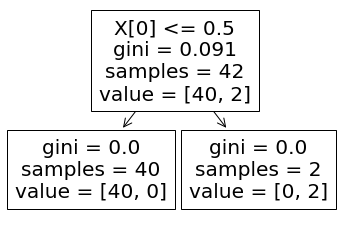

In [64]:
tree.plot_tree(dt)

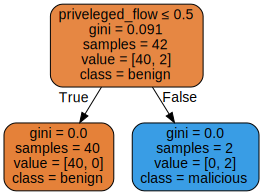

In [65]:
import graphviz
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=tempdf.columns.tolist(),  
                     class_names=['benign', 'malicious'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

## Preprocessing Testing Data 

We test on the CVEs that come after 2018 and see if the DTree Classification detects the attack. 

In [73]:
df3 = pd.read_csv("gdrive/MyDrive/Data_Prov_New/14271_features.csv")
df4 = pd.read_csv("gdrive/MyDrive/Data_Prov_New/0492_features.csv")

df2 = pd.concat([df3, df4])

### Limiting to inodes only

In [74]:
df2 = df2[(df2['object_type'] == 'link') | (df2['object_type'] == 'file') | (df2['object_type'] == 'directory') |  (df2['object_type'] == 'file,directory')|  (df2['object_type'] == 'directory,file')]
df2

,object_type,entity_path,reader_path,writer_path,namespaces,reader_relation_types,writer_relation_types,writer_argvs,reader_argvs,priviledged_flow,labels
0,file,['/var/lib/docker/overlay2/3e383c63e41c4026836...,"['/', '/usr/bin/dockerd']",['/usr/bin/dockerd'],"[1, 1, 1, 1, 1]",['getattr'],['rename'],[],[],0,0
1,file,['/var/lib/docker/overlay2/3e383c63e41c4026836...,"['/', '/usr/bin/dockerd']",['/usr/bin/dockerd'],"[1, 1, 1, 1, 1]",['getattr'],['rename'],[],[],0,0
4,file,"['/systemd/netif/state', '/systemd/netif/.#sta...",['/lib/systemd/systemd-timesyncd'],['/lib/systemd/systemd-networkd'],"[0, 1, 0, 0, 0]","['open', 'perm_check', 'read', 'getattr']","['rename', 'write']",[],[],0,0
6,file,"['/systemd/resolve/resolv.conf', '/systemd/res...",['/usr/bin/dockerd'],['/lib/systemd/systemd-resolved'],"[0, 1, 0, 0, 0]","['open', 'perm_check', 'read', 'getattr']","['rename', 'write']",[],[],0,0
7,file,['/var/lib/docker/containers/067b997e15622699d...,['/'],['/usr/bin/dockerd'],"[1, 1, 1, 1, 1]",['getattr'],['write'],[],[],0,0
8,file,['/var/lib/docker/containers/067b997e15622699d...,['/'],['/usr/bin/dockerd'],"[1, 1, 1, 1, 1]",['getattr'],['write'],[],[],0,0
9,file,"['/systemd/netif/state', '/systemd/netif/.#sta...",['/lib/systemd/systemd-timesyncd'],['/lib/systemd/systemd-networkd'],"[0, 1, 0, 0, 0]","['open', 'perm_check', 'read', 'getattr']","['rename', 'write']",[],[],0,0
10,file,"['/systemd/netif/state', '/systemd/netif/.#sta...",['/lib/systemd/systemd-timesyncd'],['/lib/systemd/systemd-networkd'],"[0, 1, 0, 0, 0]","['open', 'perm_check', 'read', 'getattr']","['rename', 'write']",[],[],0,0
18,file,"['/systemd/netif/links/9', '/systemd/netif/lin...",['/lib/systemd/systemd-resolved'],['/lib/systemd/systemd-networkd'],"[0, 1, 0, 0, 0]","['perm_check', 'open', 'read', 'getattr']","['rename', 'write']",[],[],0,0
19,file,"['/systemd/netif/state', '/systemd/netif/.#sta...",['/lib/systemd/systemd-timesyncd'],['/lib/systemd/systemd-networkd'],"[0, 1, 0, 0, 0]","['open', 'perm_check', 'read', 'getattr']","['rename', 'write']",[],[],0,0


### Feature Engineering

In [75]:
tempdf = pd.DataFrame()

In [76]:
tempdf['priveleged_flow'] = list(df2['priviledged_flow'].astype(int))
tempdf['labels'] = list(df2['labels'])
tempdf

,priveleged_flow,labels
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [77]:
df_namespace = pd.DataFrame()
df_namespace['namespaces'] = list(map(lambda x: list(map(lambda y: int(y),x.split('[')[1].split(']')[0].split(','))), df2['namespaces'].to_numpy()))
df_namespace

cols =[[],[],[],[],[]]

for i in range(5):
  for j in range(len(df_namespace)):
    cols[i].append(df_namespace.iloc[j,0][i])



tempdf['ipcns'] = cols[0]
tempdf['mntns'] = cols[1]
tempdf['netns'] = cols[2]
tempdf['pidns'] = cols[3]
tempdf['utsns'] = cols[4]

tempdf

,priveleged_flow,labels,ipcns,mntns,netns,pidns,utsns
0,0,0,1,1,1,1,1
1,0,0,1,1,1,1,1
2,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0
4,0,0,1,1,1,1,1
5,0,0,1,1,1,1,1
6,0,0,0,1,0,0,0
7,0,0,0,1,0,0,0
8,0,0,0,1,0,0,0
9,0,0,0,1,0,0,0


In [78]:
feature = "entity_path"
text = df2[feature]


vector = vectorizer1.transform(text)

print(vector.shape)
print(vector.toarray())

count_vect_df = pd.DataFrame(vector.todense(), columns=feature+"_contains_"+vectorizer1.get_feature_names_out())
print(count_vect_df.shape)

tempdf = pd.concat([tempdf,count_vect_df], axis=1)
tempdf


(32, 58)
[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(32, 58)


,priveleged_flow,labels,ipcns,mntns,netns,pidns,utsns,entity_path_contains_12,entity_path_contains_120mtdzu,entity_path_contains_12zunvx5,...,entity_path_contains_statep2bzlp,entity_path_contains_statere3vwu,entity_path_contains_stateydodkt,entity_path_contains_statezdlp7h,entity_path_contains_stub,entity_path_contains_systemd,entity_path_contains_totally_safe_path,entity_path_contains_usr,entity_path_contains_var,entity_path_contains_w00t_w00t_im_a_flag
0,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
4,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
7,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
8,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
9,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0


In [79]:
feature = "reader_path"
text = df2[feature]


vector = vectorizer2.transform(text)

print(vector.shape)
print(vector.toarray())

count_vect_df2 = pd.DataFrame(vector.todense(), columns=feature+"_contains_"+vectorizer2.get_feature_names_out())

tempdf = pd.concat([tempdf,count_vect_df2], axis=1)
tempdf

(32, 15)
[[0 1 0 0 1 0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0 0 0 2 1 0]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 2 1 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 2 1 0]
 [0 0 0 0 0 1 0 0 1 0 0 0 2 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 2 1 0]
 [0 0 0 0 0 1 0 0 1 0 0 0 2 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 2 1 0]
 [0 0 0 0 0 1 0 0 1 0 0 0 2 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 1 0 0 1]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 1 0 1 1 0 0 0 2 0 1]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 1 0 0 0 2 0 0]
 [0 0 0 0 0 1 0 0 1 0 0 0 2 0 0]
 [0 1 0 0 1 0 0 0 0 1 0 0 0 0 2]
 [0 0 0 0 0 1 0 0 1 0 0 0 2 0 0]
 [0 0 0 0 0 1 0 0 1 0 0 0 2 0 0]
 [0 0 0 0 0 1 0 0 1 0 0 0 2 0 0]
 

,priveleged_flow,labels,ipcns,mntns,netns,pidns,utsns,entity_path_contains_12,entity_path_contains_120mtdzu,entity_path_contains_12zunvx5,...,reader_path_contains_lib,reader_path_contains_networkctl,reader_path_contains_python3,reader_path_contains_resolved,reader_path_contains_runc,reader_path_contains_shim,reader_path_contains_sudo,reader_path_contains_systemd,reader_path_contains_timesyncd,reader_path_contains_usr
0,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,2,1,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,2,1,0
7,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,2,1,0
8,0,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,2,0,0
9,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,2,1,0


In [80]:

feature = "writer_path"
text = df2[feature]


vector = vectorizer3.transform(text)

print(vector.shape)
print(vector.toarray())


count_vect_df3 = pd.DataFrame(vector.todense(), columns=feature+"_contains_"+vectorizer3.get_feature_names_out())

tempdf = pd.concat([tempdf,count_vect_df3], axis=1)
tempdf

(32, 9)
[[1 0 1 0 0 0 0 0 1]
 [1 0 1 0 0 0 0 0 1]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 0 1 0 2 0]
 [1 0 1 0 0 0 0 0 1]
 [1 0 1 0 0 0 0 0 1]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 0 1 0 2 0]
 [3 0 1 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 1]
 [1 0 1 0 0 0 0 0 1]
 [1 0 1 0 0 0 0 0 1]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [1 0 1 0 0 0 0 0 1]
 [1 0 1 0 0 0 0 0 1]
 [1 0 1 0 0 0 0 0 1]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 0 1 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 1 0 0 2 0]
 [0 0 0 1 0 1 0 2 0]
 [0 0 0 0 0 0 0 0 0]]


,priveleged_flow,labels,ipcns,mntns,netns,pidns,utsns,entity_path_contains_12,entity_path_contains_120mtdzu,entity_path_contains_12zunvx5,...,reader_path_contains_usr,writer_path_contains_bin,writer_path_contains_docker,writer_path_contains_dockerd,writer_path_contains_lib,writer_path_contains_networkd,writer_path_contains_resolved,writer_path_contains_runc,writer_path_contains_systemd,writer_path_contains_usr
0,0,0,1,1,1,1,1,0,0,0,...,1,1,0,1,0,0,0,0,0,1
1,0,0,1,1,1,1,1,0,0,0,...,1,1,0,1,0,0,0,0,0,1
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,2,0
3,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,2,0
4,0,0,1,1,1,1,1,0,0,0,...,0,1,0,1,0,0,0,0,0,1
5,0,0,1,1,1,1,1,0,0,0,...,0,1,0,1,0,0,0,0,0,1
6,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,2,0
7,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,2,0
8,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,2,0
9,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,2,0


In [81]:
feature = "reader_relation_types"
text = df2[feature]


vector = vectorizer4.transform(text)

print(vector.shape)
print(vector.toarray())

count_vect_df4 = pd.DataFrame(vector.todense(), columns=feature+"_contains_"+vectorizer4.get_feature_names_out())
tempdf = pd.concat([tempdf,count_vect_df4], axis=1)
tempdf




(32, 6)
[[1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]
 [1 1 1 1 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]]


,priveleged_flow,labels,ipcns,mntns,netns,pidns,utsns,entity_path_contains_12,entity_path_contains_120mtdzu,entity_path_contains_12zunvx5,...,writer_path_contains_resolved,writer_path_contains_runc,writer_path_contains_systemd,writer_path_contains_usr,reader_relation_types_contains_getattr,reader_relation_types_contains_open,reader_relation_types_contains_perm_check,reader_relation_types_contains_read,reader_relation_types_contains_read_ioctl,reader_relation_types_contains_read_link
0,0,0,1,1,1,1,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
1,0,0,1,1,1,1,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,2,0,1,1,1,1,0,0
3,0,0,0,1,0,0,0,0,0,0,...,1,0,2,0,1,1,1,1,0,0
4,0,0,1,1,1,1,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
5,0,0,1,1,1,1,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
6,0,0,0,1,0,0,0,0,0,0,...,0,0,2,0,1,1,1,1,0,0
7,0,0,0,1,0,0,0,0,0,0,...,0,0,2,0,1,1,1,1,0,0
8,0,0,0,1,0,0,0,0,0,0,...,0,0,2,0,1,1,1,1,0,0
9,0,0,0,1,0,0,0,0,0,0,...,0,0,2,0,1,1,1,1,0,0


In [82]:
feature = "writer_relation_types"
text = df2[feature]



vector = vectorizer5.transform(text)

print(vector.shape)
print(vector.toarray())

count_vect_df5 = pd.DataFrame(vector.todense(), columns=feature+"_contains_"+vectorizer5.get_feature_names_out())
tempdf = pd.concat([tempdf,count_vect_df5], axis=1)
tempdf

(32, 2)
[[1 0]
 [1 0]
 [1 1]
 [1 1]
 [0 1]
 [0 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 1]
 [1 1]
 [0 1]
 [0 1]
 [0 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 1]]


,priveleged_flow,labels,ipcns,mntns,netns,pidns,utsns,entity_path_contains_12,entity_path_contains_120mtdzu,entity_path_contains_12zunvx5,...,writer_path_contains_systemd,writer_path_contains_usr,reader_relation_types_contains_getattr,reader_relation_types_contains_open,reader_relation_types_contains_perm_check,reader_relation_types_contains_read,reader_relation_types_contains_read_ioctl,reader_relation_types_contains_read_link,writer_relation_types_contains_rename,writer_relation_types_contains_write
0,0,0,1,1,1,1,1,0,0,0,...,0,1,1,0,0,0,0,0,1,0
1,0,0,1,1,1,1,1,0,0,0,...,0,1,1,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,0,0,...,2,0,1,1,1,1,0,0,1,1
3,0,0,0,1,0,0,0,0,0,0,...,2,0,1,1,1,1,0,0,1,1
4,0,0,1,1,1,1,1,0,0,0,...,0,1,1,0,0,0,0,0,0,1
5,0,0,1,1,1,1,1,0,0,0,...,0,1,1,0,0,0,0,0,0,1
6,0,0,0,1,0,0,0,0,0,0,...,2,0,1,1,1,1,0,0,1,1
7,0,0,0,1,0,0,0,0,0,0,...,2,0,1,1,1,1,0,0,1,1
8,0,0,0,1,0,0,0,0,0,0,...,2,0,1,1,1,1,0,0,1,1
9,0,0,0,1,0,0,0,0,0,0,...,2,0,1,1,1,1,0,0,1,1


In [83]:
feature = "reader_argvs"
text = df2[feature]

vector = vectorizer6.transform(text)

print(vector.shape)
print(vector.toarray())

count_vect_df6 = pd.DataFrame(vector.todense(), columns=feature+"_contains_"+vectorizer6.get_feature_names_out())
tempdf = pd.concat([tempdf,count_vect_df6], axis=1)
tempdf

(32, 36)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


,priveleged_flow,labels,ipcns,mntns,netns,pidns,utsns,entity_path_contains_12,entity_path_contains_120mtdzu,entity_path_contains_12zunvx5,...,reader_argvs_contains_run,reader_argvs_contains_runc,reader_argvs_contains_runtime,reader_argvs_contains_shim,reader_argvs_contains_sock,reader_argvs_contains_state,reader_argvs_contains_usr,reader_argvs_contains_v1,reader_argvs_contains_var,reader_argvs_contains_workdir
0,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
feature = "writer_argvs"
text = df2[feature]


vector = vectorizer7.transform(text)

print(vector.shape)
print(vector.toarray())

count_vect_df7 = pd.DataFrame(vector.todense(), columns=feature+"_contains_"+vectorizer7.get_feature_names_out())
tempdf = pd.concat([tempdf,count_vect_df7], axis=1)
tempdf


(32, 13)
[[0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]]


,priveleged_flow,labels,ipcns,mntns,netns,pidns,utsns,entity_path_contains_12,entity_path_contains_120mtdzu,entity_path_contains_12zunvx5,...,writer_argvs_contains_lib,writer_argvs_contains_merged,writer_argvs_contains_overlay2,writer_argvs_contains_overwrite_runc,writer_argvs_contains_proc,writer_argvs_contains_self,writer_argvs_contains_symlink_swap,writer_argvs_contains_totally_safe_path,writer_argvs_contains_untar,writer_argvs_contains_var
0,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
feature = 'object_type'

print(enc.categories_)
onehottt = enc.transform(df2[["object_type"]]).todense()
one_hot_df = pd.DataFrame(onehottt, columns=feature+"_contains_"+enc.get_feature_names_out())

one_hot_df
tempdf = pd.concat([tempdf,one_hot_df], axis=1)
tempdf

[array(['file', 'link'], dtype=object)]


,priveleged_flow,labels,ipcns,mntns,netns,pidns,utsns,entity_path_contains_12,entity_path_contains_120mtdzu,entity_path_contains_12zunvx5,...,writer_argvs_contains_overlay2,writer_argvs_contains_overwrite_runc,writer_argvs_contains_proc,writer_argvs_contains_self,writer_argvs_contains_symlink_swap,writer_argvs_contains_totally_safe_path,writer_argvs_contains_untar,writer_argvs_contains_var,object_type_contains_object_type_file,object_type_contains_object_type_link
0,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.0
1,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.0
4,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.0
5,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.0
6,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.0
7,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.0
8,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.0
9,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0.0


## Testing DTree

In [86]:
testY = tempdf['labels'].to_numpy()
del tempdf['labels']

testX = tempdf.to_numpy()
testX.shape

(32, 147)

In [87]:
y_pred = dt.predict(testX)


### Accuracy 

In [88]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

acc = accuracy_score(testY, y_pred)
print('Accuracy of the model is:', acc )

Accuracy of the model is: 1.0


In [89]:
def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [90]:
print_stats(y_pred, testY)

Accuracy = 1.0
Precision = 1.0
Recall = 1.0
